In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
fail_threshold = 0.0033
deep_dchi2 = 100
mindepth = 120

total number, total deep, min depth for deep
182043 27012 9356.199974060059
number of unique targets is 26051
34350
number, fraction of failures, fraction of failures with zwarn==0
25742 0.1468417372387538 0.08309377670732655


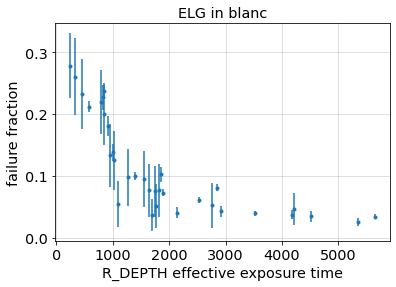

In [7]:
tp = 'ELG'
release = 'blanc'

f = fitsio.read('/project/projectdirs/desi/users/ajross/catalogs/SV/redshift_comps/'+release+'/v0/'+tp+'/alltiles_'+tp+'zinfo.fits') #fitsio *much* faster than using Table here
deep = f[f['subset']=='deep'] 
min_depth = np.max(deep['R_DEPTH'])/2

print('total number, total deep, min depth for deep')
print(len(f),len(deep),min_depth)
#get list of truez in appropriate rows, matching Rongpu's definition for criteria required to allow truth determination
#rows without truth have z==0
mzl = np.zeros(len(f))
tids = np.unique(f['TARGETID'])
print('number of unique targets is '+str(len(tids)))
for iid in tids:
    sf = f['TARGETID'] == iid
    fi = f[sf]
    fd = fi[fi['subset']=='deep']
    mask = fd['FIBERSTATUS']==0 # Remove FIBERSTATUS!=0 fibers
    mask &= fd['ZWARN'] & 2**9==0 # Remove "no data" fibers
    mask &= fd['ZWARN']==0
    mask &= fd['R_DEPTH'] > min_depth
    mask &= fd['DELTACHI2'] > deep_dchi2
    if len(fd[mask]) > 0:
        mzl[sf] = fd['Z'][0]

w = mzl != 0
print(len(mzl[w]))
tf = Table(f)
tf['Z_TRUTH'] = mzl
masknight = tf['subset'] != 'deep'
masknight &= tf['subset'] != 'all'
masknight &= tf['Z_TRUTH'] != 0
masknight &= tf['FIBERSTATUS']==0
masknight &= tf['ZWARN'] & 2**9==0
tcomp = tf[masknight]
dz = tcomp['Z'] - tcomp['Z_TRUTH']
bz = abs(dz) > fail_threshold
bzz = bz & (tcomp['ZWARN'] != 0)
print('number, fraction of failures, fraction of failures with zwarn==0')
print(len(tcomp),len(tcomp[bz])/len(tcomp),len(tcomp[bzz])/len(tcomp))
rvals = np.unique(tcomp['R_DEPTH'])
ff = []
rv = []
nb = []
nt = []
for rval in rvals:
    ds = tcomp[tcomp['R_DEPTH']==rval]
    dz = ds['Z'] - ds['Z_TRUTH']
    bz = abs(dz) > fail_threshold
    if len(ds) > 30 and rval > mindepth:
        ff.append(len(ds[bz])/len(ds))
        nb.append(len(ds[bz]))
        nt.append(len(ds))
        rv.append(rval)
nt = np.array(nt)
nb = np.array(nb)
err = ((nt-nb)*(1.-(nt-nb)/nt))**.5/nt #binomial error formula, needs double-check
plt.errorbar(rv,ff,err,fmt='.')#,label=td)

#plt.legend()
plt.grid(alpha=0.5)
plt.xlabel('R_DEPTH effective exposure time')
plt.ylabel('failure fraction')
plt.title(tp+' in '+release)
plt.show()

In [1]:
import evalSR
import importlib

In [56]:
importlib.reload(evalSR)

<module 'evalSR' from '/global/u2/a/ajross/LSS/Sandbox/evalSR.py'>

In [57]:
tf = evalSR.add_truth('LRG')

number of unique targets is 14100


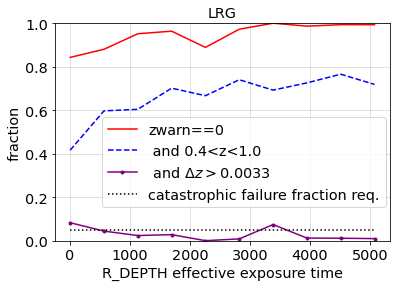

In [58]:
evalSR.effvsdepth(tf,'LRG',nbin=10,lplace=(.12,.12))

In [59]:
tf = evalSR.add_truth('ELG')

number of unique targets is 26051


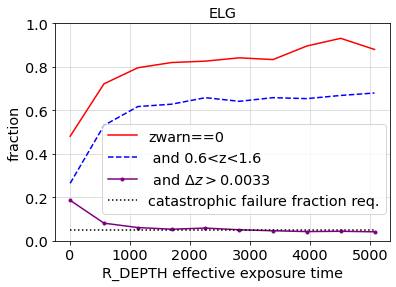

In [62]:
evalSR.effvsdepth(tf,'ELG',nbin=10,lplace=(.12,.09))

number of unique targets is 8728


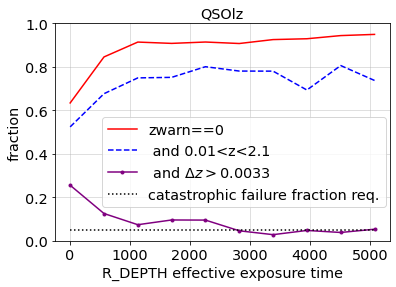

In [63]:
tf = evalSR.add_truth('QSO')
evalSR.effvsdepth(tf,'QSOlz',nbin=10,lplace=(.12,.12))

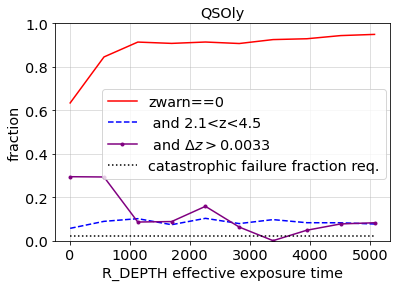

In [64]:
evalSR.effvsdepth(tf,'QSOly',nbin=10,lplace=(.12,.25))

number of unique targets is 27272


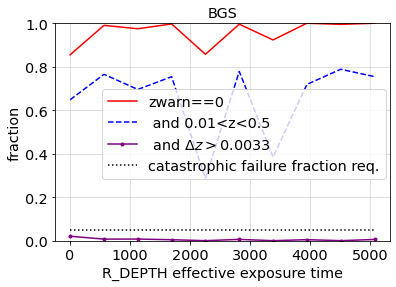

In [65]:
tf = evalSR.add_truth('BGS_ANY')
evalSR.effvsdepth(tf,'BGS',nbin=10,lplace=(.12,.25))

(array([ 90.,  11.,   0.,   0.,   0.,  25.,  11.,   7.,  53.,  26.,   6.,
         18.,  30.,  40.,  42.,  84., 137., 157., 151., 273.,  64., 141.,
        237.,  94., 297., 221., 339., 193., 203., 162., 271., 154., 206.,
        211., 294., 128.,  75.,  87., 101.,  40.,  63.,  25.,   9.,  42.,
         14.,  11.,  29.,  21.,   0.,  32.,  28.,   0.,   0.,   0.,   0.,
          0.,   6.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,  14.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,  14.,   0.,   0.,   0.,
         11.]),
 array([-0.0019957 ,  0.01301323,  0.02802217,  0.04303111,  0.05804004,
         0.07304898,  0.08805792,  0.10306685,  0.11807579,  0.13308473,
         0.14809366,  0.1631026 ,  0.17811153,  0.19312047,  0.20812941,
         0.22313834,  0.23814728,  0.25315622,  0.26816515,  0.28317409,
         0.29818302,  0.31

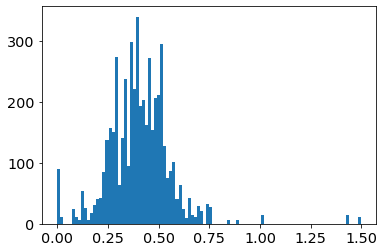

In [50]:
wt = tf['Z_TRUTH'] != 0
plt.hist(tf['Z_TRUTH'][wt],bins=100)

In [46]:
from matplotlib import pyplot as plt

In [54]:
wz = wt & (tf['Z_TRUTH'] > 0.01) & (tf['Z_TRUTH'] < 0.5)

In [55]:
len(tf[wz])/len(tf[wt])

0.7498501498501499